In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [28]:
#load data
ball_df = pd.read_csv('../data/results/ball_positions_interpolated.csv')
gk_df = pd.read_csv('../data/raw/gk_positions.csv')

ball_df = ball_df.rename(columns={"X": "ball_x", "Y": "ball_y"})
gk_df.columns = gk_df.columns.str.strip()  # Remove leading/trailing spaces
gk_df = gk_df.rename(columns={"X": "gk_x", "Y": "gk_y"})

#merge by frame
df = pd.merge(ball_df, gk_df, on="Frame", how="inner").sort_values("Frame")

#mark missing gk values
df["gk_missing"] = df[["gk_x", "gk_y"]].isnull().any(axis=1)

#Normalize
ball_min = df[["ball_x", "ball_y"]].min()
ball_max = df[["ball_x", "ball_y"]].max()
df[["ball_x", "ball_y"]] = (df[["ball_x", "ball_y"]] - ball_min) / (ball_max - ball_min)

gk_min = df[["gk_x", "gk_y"]].min()
gk_max = df[["gk_x", "gk_y"]].max()
df[["gk_x", "gk_y"]] = (df[["gk_x", "gk_y"]] - gk_min) / (gk_max - gk_min)

In [30]:
#create sequences for training
SEQ_LEN = 15
X_train, y_train = [], []

for i in range(SEQ_LEN, len(df)):
    if not df["gk_missing"].iloc[i]:  # only use frames where GK position is known
        ball_seq = df[["ball_x", "ball_y"]].iloc[i-SEQ_LEN:i].values
        gk_target = df[["gk_x", "gk_y"]].iloc[i].values
        X_train.append(ball_seq)
        y_train.append(gk_target)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

LSTM

In [31]:
#define lstm model
class BallToGK_LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, output_size=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])  # last layer's hidden state

model = BallToGK_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [32]:
#train model
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

EPOCHS = 100
for epoch in range(EPOCHS):
    total_loss = 0
    for xb, yb in dataloader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss:.4f}")

Epoch 0: Loss = 0.2208
Epoch 10: Loss = 0.0763
Epoch 20: Loss = 0.0573
Epoch 30: Loss = 0.0577
Epoch 40: Loss = 0.0526
Epoch 50: Loss = 0.0438
Epoch 60: Loss = 0.0281
Epoch 70: Loss = 0.0175
Epoch 80: Loss = 0.0156
Epoch 90: Loss = 0.0145


In [33]:
#predict missing gk values
df["gk_pred_x"] = np.nan
df["gk_pred_y"] = np.nan

for i in range(SEQ_LEN, len(df)):
    if df["gk_missing"].iloc[i]:  # if GK is missing, predict
        ball_seq = df[["ball_x", "ball_y"]].iloc[i-SEQ_LEN:i].values
        ball_tensor = torch.tensor(ball_seq, dtype=torch.float32).unsqueeze(0)  # add batch dim
        with torch.no_grad():
            pred = model(ball_tensor).squeeze().numpy()
        # De-normalize prediction
        gk_x = pred[0] * (gk_max["gk_x"] - gk_min["gk_x"]) + gk_min["gk_x"]
        gk_y = pred[1] * (gk_max["gk_y"] - gk_min["gk_y"]) + gk_min["gk_y"]
        df.at[df.index[i], "gk_pred_x"] = gk_x
        df.at[df.index[i], "gk_pred_y"] = gk_y

In [37]:
#merge predictions with original data
# Replace missing GK positions with predictions
df["gk_x"] = df["gk_x"].combine_first(df["gk_pred_x"])
df["gk_y"] = df["gk_y"].combine_first(df["gk_pred_y"])

# Drop the prediction columns if no longer needed
df = df.drop(columns=["gk_pred_x", "gk_pred_y"])

In [38]:
#save results
df.to_csv("../data/results/gk_prediction_output.csv", index=False)

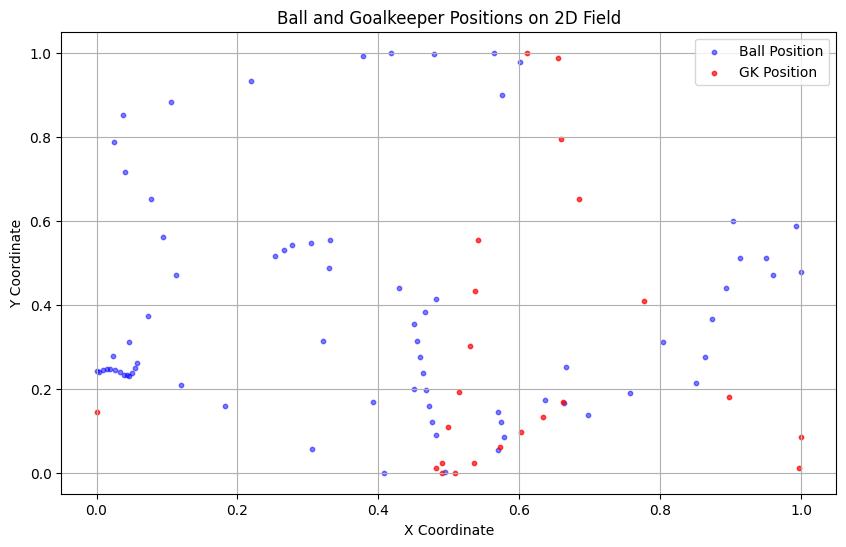

In [39]:
#on a 2d field, plot the ball and gk positions
import matplotlib.pyplot as plt

# Filter rows where GK positions are available
gk_available = df[~df["gk_missing"]]

# Plot ball positions
plt.figure(figsize=(10, 6))
plt.scatter(df["ball_x"], df["ball_y"], color="blue", label="Ball Position", alpha=0.5, s=10)

# Plot GK positions
plt.scatter(gk_available["gk_x"], gk_available["gk_y"], color="red", label="GK Position", alpha=0.7, s=10)

# Add labels and legend
plt.title("Ball and Goalkeeper Positions on 2D Field")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid(True)
plt.show()